# Challenge

Do a little scraping or API-calling of your own.  Pick a new website and see what you can get out of it.  Expect that you'll run into bugs and blind alleys, and rely on your mentor to help you get through.  

Formally, your goal is to write a scraper that will:

1) Return specific pieces of information (rather than just downloading a whole page)  
2) Iterate over multiple pages/queries  
3) Save the data to your computer  

Once you have your data, compute some statistical summaries and/or visualizations that give you some new insights into your scraping topic of interest.  Write up a report from scraping code to summary and share it with your mentor.

In [1]:
import sys
from scrapy.spiders import Spider
from scrapy.selector import Selector
from scrapy.crawler import CrawlerProcess
import pandas as pd
import re
import matplotlib.pyplot as plt
import os
import numpy as np

if os.path.isfile('Yelp2.json'):
    os.remove('Yelp2.json')

class YelpSpider(Spider):
    name = "yelp"
    allowed_domains = ["yelp.com"]
    start_urls = ["http://www.yelp.com/search?find_desc=Asian&find_loc=MI&start=0"]
    for i in range(1,99):
            start_urls.append("http://www.yelp.com/search?find_desc=Asian&find_loc=MI&start="+str(i*10))

    names = []
    raiting = []
    cost = []
    rewiew_counts = []
    catigories = []
    
    def parse(self, response):
        listings = response.xpath("//li[@class='regular-search-result']")
        for results in listings:
            yield{
            'raw_name' : results.xpath(".//span[@class='indexed-biz-name']/a//text()").extract_first(),
            'stars' : results.xpath(".//div[contains(@class,'rating-large')]//@title").extract_first(),
            'price' : results.xpath(".//span[contains(@class,'price-range')]//text()").extract_first(),
            'raw_review_count' : results.xpath(".//span[contains(@class,'review-count')]//text()").extract_first(),
            'category_list' : results.xpath(".//span[contains(@class,'category-str-list')]//a//text()").extract()    
            }
    
process = CrawlerProcess({
    'FEED_FORMAT': 'json',
    'FEED_URI': 'Yelp2.json',
    # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
    'ROBOTSTXT_OBEY': False,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False,
    # We use CLOSESPIDER_PAGECOUNT to limit our scraper to the first 100 links.    
    'CLOSESPIDER_PAGECOUNT' : 99
})                

# Starting the crawler with our spider.
process.crawl(YelpSpider)
process.start()

In [2]:
Yelpdata=pd.read_json('Yelp2.json', orient='records')

In [3]:
Yelpdata.price = Yelpdata.price.apply(lambda x : len(str(x)) )

Yelpdata.stars = Yelpdata.stars.apply(lambda x : str(x)[:3])
Yelpdata.stars = Yelpdata.stars.apply(lambda x : float(x.replace('Non', '0')))

Yelpdata.raw_review_count = Yelpdata.raw_review_count.apply(lambda x : re.findall('\d+', str(x)))
Yelpdata.raw_review_count = Yelpdata.raw_review_count.apply(lambda x : [0] if len(x) == 0 else x)
Yelpdata.raw_review_count = Yelpdata.raw_review_count.apply(lambda x : int(x[0]))

In [4]:
Yelpdata.head()

,category_list,price,raw_name,raw_review_count,stars
0,"[Noodles, Soup]",2,ima,89,4.5
1,[Thai],2,Takoi,216,4.5
2,"[Ramen, Chinese, Noodles]",2,Johnny Noodle King,436,4.0
3,"[Hawaiian, Poke, Asian Fusion]",1,Gogo’s,70,4.0
4,"[Sushi Bars, Seafood]",2,Maru Sushi & Grill Detroit,133,4.0


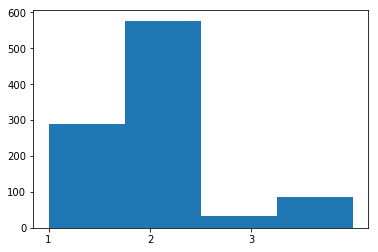

In [5]:
plt.hist(Yelpdata.price, bins = 4)
plt.xticks(range(1,4))
plt.show()

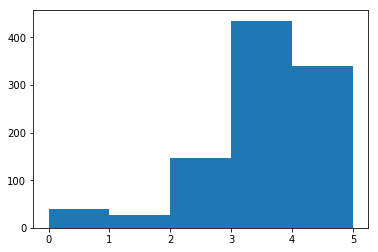

In [6]:
plt.hist(Yelpdata.stars, bins = 5)
plt.show()

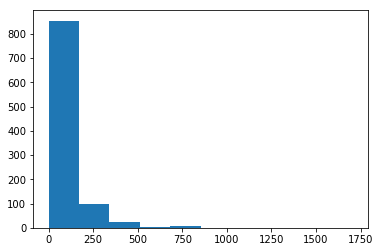

In [7]:
plt.hist(Yelpdata.raw_review_count)
plt.show()

In [8]:
Yelpdata[Yelpdata.raw_review_count == Yelpdata.raw_review_count.max()]

,category_list,price,raw_name,raw_review_count,stars
143,"[Barbeque, Beer Bar, American (Traditional)]",2,Slows Bar BQ,1707,4.0


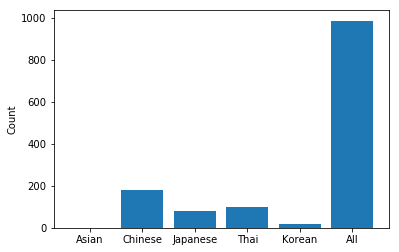

In [12]:
Chineserestaurantsnum = len(Yelpdata[Yelpdata.category_list.apply(lambda x : 'Chinese' in x)])
Japaneserestaurantsnum = len(Yelpdata[Yelpdata.category_list.apply(lambda x : 'Japanese' in x)])
Thairestaurantsnum = len(Yelpdata[Yelpdata.category_list.apply(lambda x : 'Thai' in x)])
Koreanrestaurantsnum = len(Yelpdata[Yelpdata.category_list.apply(lambda x : 'Korean' in x)])
Asianrestaurantsnum = len(Yelpdata[Yelpdata.category_list.apply(lambda x : 'Asian' in x)])

names = ['Asian','Chinese','Japanese','Thai','Korean', 'All']
data = [Asianrestaurantsnum,
        Chineserestaurantsnum,
        Japaneserestaurantsnum,
        Thairestaurantsnum,
        Koreanrestaurantsnum, 
        len(Yelpdata)]

y_pos = np.arange(len(data))
plt.bar(y_pos, data, align='center')
plt.xticks(y_pos, names)
plt.ylabel('Count')
plt.show()

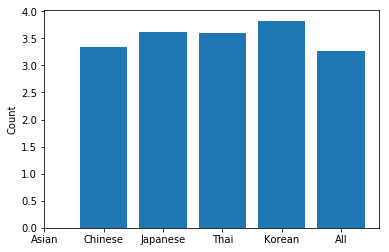

In [14]:
Chineserestaurantsstaravg = Yelpdata[Yelpdata.category_list.apply(lambda x : 'Chinese' in x)].stars.mean()
Japaneserestaurantsnumstaravg = Yelpdata[Yelpdata.category_list.apply(lambda x : 'Japanese' in x)].stars.mean()
Thairestaurantsnumstaravg = Yelpdata[Yelpdata.category_list.apply(lambda x : 'Thai' in x)].stars.mean()
Koreanrestaurantsnumstaravg = Yelpdata[Yelpdata.category_list.apply(lambda x : 'Korean' in x)].stars.mean()
Asianrestaurantsnumstaravg = Yelpdata[Yelpdata.category_list.apply(lambda x : 'Asian' in x)].stars.mean()

names = ['Asian','Chinese','Japanese','Thai','Korean', 'All']
data = [Asianrestaurantsnumstaravg,
        Chineserestaurantsstaravg,
        Japaneserestaurantsnumstaravg,
        Thairestaurantsnumstaravg,
        Koreanrestaurantsnumstaravg, 
        Yelpdata.stars.mean()]

y_pos = np.arange(len(data))
plt.bar(y_pos, data, align='center')
plt.xticks(y_pos, names)
plt.ylabel('Count')
plt.show()


In [11]:
#Yelpdata[Yelpdata.raw_review_count >= Yelpdata.raw_review_count.mean()].sort_values('raw_review_count', ascending = False)